In [16]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import pickle
import os
import time

import seaborn as sns
sns.set()
from matplotlib import style
# style.use('ggplot')

In [17]:
df = pd.read_csv('sp500_wti.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197718 entries, 0 to 1197717
Data columns (total 34 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Date                       1197718 non-null  datetime64[ns]
 1   Adj Close                  1197718 non-null  float64       
 2   volume_obv                 1197718 non-null  float64       
 3   volume_fi                  1197718 non-null  float64       
 4   volatility_bbm             1197718 non-null  float64       
 5   volatility_bbw             1197718 non-null  float64       
 6   volatility_bbhi            1197718 non-null  float64       
 7   volatility_bbli            1197718 non-null  float64       
 8   trend_macd                 1197718 non-null  float64       
 9   trend_macd_signal          1197718 non-null  float64       
 10  trend_macd_diff            1197718 non-null  float64       
 11  trend_psar_up_indicator    1197718 no

In [18]:
def cat_cont_split(df, maxcard=55, omit_vars=['Date', 'Adj Close', 'Return', 'target_return']):
    """Helper function that returns column names of categorical & continuous features from df."""
    cat_feats, cont_feats = [], []
    for col in df:
        if col in omit_vars: 
            continue
        if (df[col].dtype==int or df[col].dtype==float) and df[col].unique().shape[0] > maxcard:
            cont_feats.append(col)
        else:
            cat_feats.append(col)
    return cat_feats, cont_feats
    
cat_vars, cont_vars = cat_cont_split(df)
print(len(cat_vars), 'Categorical Features:')
print(cat_vars)
print(len(cont_vars), 'Continuous Features:')
print(cont_vars)

19 Categorical Features:
['volatility_bbhi', 'volatility_bbli', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'ticker', 'exchange', 'sector', 'industry', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
11 Continuous Features:
['volume_obv', 'volume_fi', 'volatility_bbm', 'volatility_bbw', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'momentum_ao', 'momentum_roc', 'Dayofyear', 'Elapsed']


In [19]:
# print(len(cat_vars), len(cont_vars))
# df.describe()

In [20]:
class Categorifier:
    ''' Transform categorical features into category types '''
    def apply_train(self, df, cat_vars):
        self.cat_vars = cat_vars
        self.categories = {}
        for v in self.cat_vars:
            df.loc[:, v] = df.loc[:, v].astype('category').cat.as_ordered()
            self.categories[v] = df[v].cat.categories
            
    def apply_test(self, df_test):
        for v in self.cat_vars:
            df_test.loc[:, v] = pd.Categorical(df[v], categories=self.categories[v], ordered=True)

cat = Categorifier()
cat.apply_train(df, cat_vars)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197718 entries, 0 to 1197717
Data columns (total 34 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Date                       1197718 non-null  datetime64[ns]
 1   Adj Close                  1197718 non-null  float64       
 2   volume_obv                 1197718 non-null  float64       
 3   volume_fi                  1197718 non-null  float64       
 4   volatility_bbm             1197718 non-null  float64       
 5   volatility_bbw             1197718 non-null  float64       
 6   volatility_bbhi            1197718 non-null  category      
 7   volatility_bbli            1197718 non-null  category      
 8   trend_macd                 1197718 non-null  float64       
 9   trend_macd_signal          1197718 non-null  float64       
 10  trend_macd_diff            1197718 non-null  float64       
 11  trend_psar_up_indicator    1197718 no

In [21]:
df.describe()

,Adj Close,volume_obv,volume_fi,volatility_bbm,volatility_bbw,trend_macd,trend_macd_signal,trend_macd_diff,momentum_ao,momentum_roc,Return,target_return,Dayofyear,Elapsed
count,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06
mean,2.591268e+00,7.303894e+01,1.843599e-05,2.315740e+00,2.399355e-01,8.452663e-03,8.466540e-03,1.277652e-04,1.784300e-02,6.953162e-01,6.006663e-02,5.977433e-02,1.819516e+02,1.424747e+09
std,2.318143e+00,5.691948e+02,6.169358e-01,2.165420e+00,3.745992e-01,6.712947e-02,6.300806e-02,2.031146e-02,1.697995e-01,5.748798e+00,1.732757e+00,1.732488e+00,1.054133e+02,9.181067e+07
min,1.140688e-01,-2.179233e+04,-2.253191e+02,1.071531e-01,0.000000e+00,-2.367287e+00,-2.048775e+00,-1.112718e+00,-6.488795e+00,-5.931778e+01,-6.189338e+01,-6.189338e+01,2.000000e+00,1.262650e+09
25%,1.296095e+00,7.519720e+00,-3.691836e-03,1.200374e+00,9.376011e-02,-1.102848e-02,-9.943336e-03,-5.117796e-03,-2.941598e-02,-2.364635e+00,-7.458466e-01,-7.459848e-01,9.000000e+01,1.345680e+09
50%,1.967868e+00,3.641876e+01,6.343970e-04,1.732195e+00,1.511008e-01,6.766243e-03,6.660563e-03,2.658306e-04,1.459041e-02,7.744420e-01,7.058580e-02,7.039026e-02,1.820000e+02,1.426205e+09
75%,3.098650e+00,7.559374e+01,5.133156e-03,2.673131e+00,2.606259e-01,2.512427e-02,2.405540e-02,5.605973e-03,6.025717e-02,3.787397e+00,8.851387e-01,8.848415e-01,2.740000e+02,1.504051e+09
max,5.483901e+01,2.438403e+04,1.216110e+02,5.273659e+01,2.088635e+01,2.726452e+00,2.488435e+00,1.231475e+00,7.642687e+00,1.104421e+02,6.190656e+01,6.190656e+01,3.660000e+02,1.581984e+09


In [22]:
class Normalizer:
    ''' Normalize continuous features '''
    def apply_train(self, df, cont_vars, by_var='ticker'):
        ''' compute mean & std of continous columns to normalize them '''
        self.cont_vars = cont_vars
        groups = df[cont_vars+[by_var]].groupby(by_var)
        self.means = groups.mean()
        self.stds = groups.std()
        df = df.merge(self.means, on='ticker', suffixes=["", "_mean"])
        df = df.merge(self.stds, on='ticker', suffixes=["", "_std"])
        for v in cont_vars:
            df[v] = (df[v] - df[v+"_mean"]) / (df[v+"_std"] + 1e-7)
        df = df.loc[:, ~df.columns.str.contains("_mean")]
        df = df.loc[:, ~df.columns.str.contains("_std")]
        return df
            
    def apply_test(self, df_test):
        df_test = df_test.merge(self.means, on='ticker', suffixes=["", "_mean"])
        df_test = df_test.merge(self.stds, on='ticker', suffixes=["", "_std"])
        for v in cont_vars:
            df_test[v] = (df_test[v] - df_test[v+"_mean"]) / (df_test[v+"_std"] + 1e-7)
        df_test = df_test.loc[:, ~df_test.columns.str.contains("_mean")]
        df_test = df_test.loc[:, ~df_test.columns.str.contains("_std")]
        return df_test 
    
norm = Normalizer()
df = norm.apply_train(df, cont_vars)
df.describe()

,Adj Close,volume_obv,volume_fi,volatility_bbm,volatility_bbw,trend_macd,trend_macd_signal,trend_macd_diff,momentum_ao,momentum_roc,Return,target_return,Dayofyear,Elapsed
count,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06,1.197718e+06
mean,2.591268e+00,1.936674e-17,6.367210e-18,2.305796e-16,4.608306e-17,1.029284e-18,6.358126e-18,-8.253736e-18,-4.589879e-18,-8.718600e-18,6.006663e-02,5.977433e-02,-2.006377e-16,3.367437e-16
std,2.318143e+00,9.997979e-01,9.997883e-01,9.997977e-01,9.997970e-01,9.997945e-01,9.997943e-01,9.997872e-01,9.997966e-01,9.997979e-01,1.732757e+00,1.732488e+00,9.997979e-01,9.997979e-01
min,1.140688e-01,-5.548671e+00,-2.611036e+01,-2.852210e+00,-2.279424e+00,-8.491944e+00,-7.830219e+00,-1.164732e+01,-1.054811e+01,-8.788867e+00,-6.189338e+01,-6.189338e+01,-1.847429e+00,-1.738438e+00
25%,1.296095e+00,-7.851574e-01,-2.097802e-01,-8.361671e-01,-6.773124e-01,-5.354872e-01,-5.391395e-01,-5.104959e-01,-5.151261e-01,-5.834816e-01,-7.458466e-01,-7.459848e-01,-8.704449e-01,-8.675707e-01
50%,1.967868e+00,3.985786e-02,5.773940e-02,-9.535070e-02,-2.723945e-01,1.952256e-02,1.681494e-02,1.393621e-02,1.941822e-02,1.862389e-02,7.058580e-02,7.039026e-02,-6.382005e-03,1.884494e-03
75%,3.098650e+00,7.787291e-01,3.047057e-01,7.501092e-01,4.032147e-01,5.761809e-01,5.793571e-01,5.365205e-01,5.632232e-01,6.004430e-01,8.851387e-01,8.848415e-01,8.656586e-01,8.666552e-01
max,5.483901e+01,4.127406e+00,2.466181e+01,4.660579e+00,1.210859e+01,7.259412e+00,7.088824e+00,8.056499e+00,7.694292e+00,8.110717e+00,6.190656e+01,6.190656e+01,1.770744e+00,1.751310e+00


In [23]:
df[df.isnull().any(axis=1)]

,Date,Adj Close,volume_obv,volume_fi,volatility_bbm,volatility_bbw,volatility_bbhi,volatility_bbli,trend_macd,trend_macd_signal,trend_macd_diff,trend_psar_up_indicator,trend_psar_down_indicator,momentum_ao,momentum_roc,Return,target_return,ticker,exchange,sector,industry,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed


In [24]:
from fastai.tabular import *

In [25]:
last_day = df['Date'].max()
cut_day = last_day + dt.timedelta(-90)
train_df = df[df['Date'] <= cut_day].sort_values(by='Date', ascending=False).reset_index(drop=True)
test_df = df[(df['Date'] > cut_day) & (df['Date'] < last_day)].sort_values(by='Date', ascending=False).reset_index(drop=True)
train_df.shape, test_df.shape, train_df.Date.min(), train_df.Date.max(), test_df.Date.min(), test_df.Date.max()

((1169210, 34),
 (28025, 34),
 Timestamp('2010-01-05 00:00:00'),
 Timestamp('2019-11-20 00:00:00'),
 Timestamp('2019-11-21 00:00:00'),
 Timestamp('2020-02-14 00:00:00'))

In [26]:
train_df.Date.min(), train_df.Date.max(), test_df.Date.min(), test_df.Date.max()

(Timestamp('2010-01-05 00:00:00'),
 Timestamp('2019-11-20 00:00:00'),
 Timestamp('2019-11-21 00:00:00'),
 Timestamp('2020-02-14 00:00:00'))

In [27]:
# cut = df['Date'][(df['Date']==df['Date'][len(test_df)])]
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
valid_idx = range(cut)

In [61]:
data = (
        TabularList.from_df(train_df, cat_names=cat_vars, cont_names=cont_vars+['Return'])
        .split_none()
#         .split_by_idx(valid_idx)
        .label_from_df(cols='target_return', label_cls=FloatList)
        .add_test(TabularList.from_df(test_df, cat_names=cat_vars, cont_names=cont_vars+['Return']))
        .databunch()
        )

In [78]:
train_df.shape

(1169210, 34)

In [85]:
data.train_ds.

array([0, 1, 2, 3, ..., 1169206, 1169207, 1169208, 1169209], dtype=object)

In [62]:
learn = tabular_learner(data, layers=[1024, 512], 
                        ps=[0.001, 0.01], emb_drop=0.1, metrics=rmse)

In [63]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 3)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(486, 51)
    (5): Embedding(3, 3)
    (6): Embedding(13, 7)
    (7): Embedding(105, 22)
    (8): Embedding(12, 6)
    (9): Embedding(13, 7)
    (10): Embedding(54, 15)
    (11): Embedding(32, 11)
    (12): Embedding(6, 4)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(3, 3)
    (16): Embedding(3, 3)
    (17): Embedding(3, 3)
    (18): Embedding(2, 2)
  )
  (emb_drop): Dropout(p=0.1, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=167, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU(

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


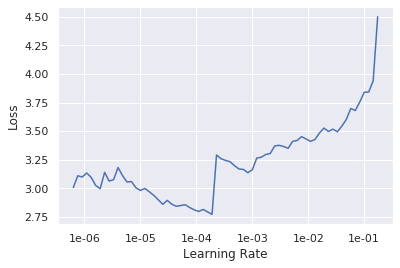

In [64]:
learn.lr_find()
learn.recorder.plot()

In [65]:
learn.fit_one_cycle(2, 1e-3, wd=0.2)

In [66]:
learn.fit_one_cycle(2, 3e-4, wd=0.2)

In [67]:
learn.fit_one_cycle(2, 1e-4, wd=0.2)

In [68]:
learn.save('stage0')
learn.load('stage0')

Learner(data=TabularDataBunch;

Train: LabelList (1169210 items)
x: TabularList
volatility_bbhi 0.0; volatility_bbli 0.0; trend_psar_up_indicator 0.0; trend_psar_down_indicator 0.0; ticker ZTS; exchange NYSE; sector HEALTH CARE; industry MAJOR PHARMACEUTICALS; Year 2019; Month 11; Week 47; Day 20; Dayofweek 2; Is_month_end False; Is_month_start False; Is_quarter_end False; Is_quarter_start False; Is_year_end False; Is_year_start False; volume_obv 1.6446; volume_fi -0.2759; volatility_bbm 2.1173; volatility_bbw 2.7786; trend_macd -2.5376; trend_macd_signal -2.6303; trend_macd_diff -0.2548; momentum_ao -2.8476; momentum_roc -1.2548; Dayofyear 1.3466; Elapsed 1.6133; Return -0.6399; ,volatility_bbhi 0.0; volatility_bbli 0.0; trend_psar_up_indicator 0.0; trend_psar_down_indicator 0.0; ticker WAB; exchange NYSE; sector CAPITAL GOODS; industry RAILROADS; Year 2019; Month 11; Week 47; Day 20; Dayofweek 2; Is_month_end False; Is_month_start False; Is_quarter_end False; Is_quarter_start False; 

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def MAE(y, y_hat):
    return np.mean(np.abs(y_hat-y))

def MAPE(y, y_hat):
    return np.mean(np.abs(y_hat-y) / (y+1e-2)) * 100

def RMSE(y, y_hat):
    return np.sqrt(np.mean((y_hat - y)**2))

def RMSPE(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / (y+1e-2)) ** 2))

# rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def scores(y, y_hat):
    return [MAE(y, y_hat), MAPE(y, y_hat), RMSE(y, y_hat), RMSPE(y, y_hat)]
#     score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
#     print('Mean', score.mean())
#     print('Variance', score.var())
#     print('MAE', MAE(y_test, y_hat))
#     print('MAPE', MAPE(y_test, y_hat))
#     print('RMSE', RMSE(y_test, y_hat))
#     print('RMSPE', RMSPE(y_test, y_hat))

In [69]:
train_df.shape, test_df.shape

((1169210, 34), (28025, 34))

In [91]:
# i = 0
# for n, c in test_df.items():
#     if i > 10:
#         break
#     print(n, c.values)
#     i += 1
test_df['Return'].values.shape

(28025,)

In [76]:
train_preds, train_target = learn.get_preds(ds_type=DatasetType.Train)
train_preds.shape, train_target.shape, train_df.shape

(torch.Size([1169152, 1]), torch.Size([1169152]), (1169210, 34))

In [72]:
# train_preds_df = pd.DataFrame(train_preds, columns=['yhat'])
# train_preds_df.head()
train_preds[:10].numpy().flatten()

array([ 0.173237, -1.133298,  0.390992,  1.391891,  1.456292,  0.441218,  0.963094,  0.10618 , -0.087304, -0.915865],
      dtype=float32)

In [73]:
# train_preds.shape, train_target.shape
# temp = test_df.loc[test_df['ticker']=='AAPL', 'Date']
train_dates = train_df.Date.unique()
test_dates = test_df.Date.unique()

is_sorted = lambda A : np.all(A[:-1] > A[1:])
is_sorted(train_dates), is_sorted(test_dates)
# train_df.head()

(True, True)

In [74]:
# learn.predict(test_df)
test_preds,test_target = learn.get_preds(ds_type=DatasetType.Test)
test_preds.shape

torch.Size([28025, 1])

In [28]:
test_df['target_return'].shape, y.shape

((9177,), torch.Size([9177]))

In [51]:
ticker = 'AMZN'
test_df[test_df.ticker==ticker].index
idx = test_df[test_df.ticker==ticker].index
yhat = preds[idx].numpy().flatten()
y = test_df.iloc[idx]['target_return'].values


(array([ 0.395871, -0.191948,  0.310569,  1.373327,  0.552311, -0.084896,  0.452451,  0.208345,  0.229468,  0.647111,
        -0.557071, -0.27676 ,  1.47051 ,  0.407054,  0.618415,  0.095347,  0.551248,  0.446455,  1.441535],
       dtype=float32),
 array([ 0.974289, -0.697717, -0.468976,  0.427746,  0.791511,  2.627346,  1.416917,  0.507875, -0.478122,  2.268734,
        -0.22502 ,  7.37913 ,  0.682457,  0.256306,  1.36244 , -1.788748, -1.217244, -0.152586, -0.23996 ]))

In [59]:
train_df.shape, train_preds.shape

((1169210, 34), torch.Size([1141056, 1]))

In [75]:
tickers = df.ticker.unique().tolist()
# test_metrics = pd.DataFrame(columns=['ticker', 'MAE', 'MAPE', 'RMSE', 'RMSPE'])
train_metrics, test_metrics = [], []
train_preds_df = pd.DataFrame(index=train_dates)
test_preds_df = pd.DataFrame(index=test_dates)

for i, ticker in enumerate(tickers):
#     print("\n##### {} {}:".format(i, ticker))
    ## Training Metrics
    idx = train_df[train_df.ticker==ticker].index
    y = train_df.iloc[idx]['target_return'].values
    yhat = train_preds[idx].numpy().flatten()
    pred_temp = pd.DataFrame(yhat, index=train_df.iloc[idx, 'Date'], columns=[ticker])
    train_preds_df = pd.merge(train_preds_df, pred_temp)
#     train_preds_df[ticker] = yhat
    temp = dict(zip(['MAE', 'MAPE', 'RMSE', 'RMSPE'], scores(y, yhat)))
    temp['ticker'] = ticker
    train_metrics.append(temp)
    ## Test Metrics
    idx = test_df[test_df.ticker==ticker].index
    yhat = test_preds[idx].numpy().flatten()
    y = test_df.iloc[idx]['target_return'].values
    test_preds_df[ticker] = yhat
    temp = dict(zip(['MAE', 'MAPE', 'RMSE', 'RMSPE'], scores(y, yhat)))
    temp['ticker'] = ticker
    test_metrics.append(temp)
train_metrics = pd.DataFrame(train_metrics)
test_metrics = pd.DataFrame(test_metrics)
# print(test_metrics)

IndexError: index 1169209 is out of bounds for dimension 0 with size 1169152

In [29]:
idx = test_df[test_df.ticker==ticker].index
idx

Int64Index([ 212,  947, 1276, 1746, 2254, 2773, 3065, 3540, 4197, 4616, 5004,
            5386, 5992, 6511, 6887, 7348, 8190, 8229, 8899],
           dtype='int64')

In [32]:
test_df.iloc[idx]['target_return']

212     0.974289
947    -0.697717
1276   -0.468976
1746    0.427746
2254    0.791511
2773    2.627346
3065    1.416917
3540    0.507875
4197   -0.478122
4616    2.268734
5004   -0.225020
5386    7.379130
5992    0.682457
6511    0.256306
6887    1.362440
7348   -1.788748
8190   -1.217244
8229   -0.152586
8899   -0.239960
Name: target_return, dtype: float64

In [33]:
preds[idx]

tensor([[ 0.3959],
        [-0.1919],
        [ 0.3106],
        [ 1.3733],
        [ 0.5523],
        [-0.0849],
        [ 0.4525],
        [ 0.2083],
        [ 0.2295],
        [ 0.6471],
        [-0.5571],
        [-0.2768],
        [ 1.4705],
        [ 0.4071],
        [ 0.6184],
        [ 0.0953],
        [ 0.5512],
        [ 0.4465],
        [ 1.4415]])

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [18]:
for i, v in enumerate(cat_vars):
    print(i, v)

0 volatility_bbhi
1 volatility_bbli
2 trend_psar_up_indicator
3 trend_psar_down_indicator
4 ticker
5 exchange
6 sector
7 industry
8 Year
9 Month
10 Week
11 Day
12 Dayofweek
13 Is_month_end
14 Is_month_start
15 Is_quarter_end
16 Is_quarter_start
17 Is_year_end
18 Is_year_start


(13, 2)


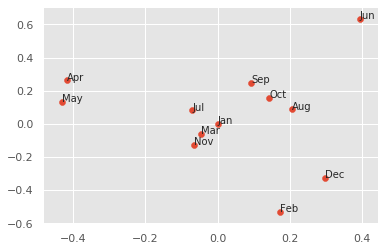

In [19]:
# Month
moy_id = 9
moy_weights = to_np(next(learn.layer_groups[0][moy_id].parameters()))
# moy_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(moy_weights)
# moy_2d.shape
# moy_2d = TSNE(n_components=2, metric='cosine').fit_transform(moy_weights)
moy_2d = PCA(n_components=2).fit(moy_weights.T).components_.T
print(moy_2d.shape)

plt.figure()
moy_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']#, 'NA']
plt.scatter(moy_2d[:-1, 0], moy_2d[:-1, 1])#, c=range(len(moy_names)))
for p, s in zip(moy_2d, moy_names):
    plt.annotate(s=s, xy=(p[0], p[1]))

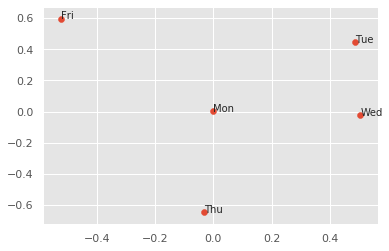

In [20]:
# Dayofweek
dow_id = 12
dow_weights = to_np(next(learn.layer_groups[0][dow_id].parameters()))
# dow_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(dow_weights)
# dow_2d = TSNE(n_components=2, metric='cosine').fit_transform(dow_temp)
dow_2d = PCA(n_components=2).fit(dow_weights.T).components_.T
plt.figure()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
# plt.plot(emb2d[:, 0], emb2d[:, 1], 'ro', )
plt.scatter(dow_2d[:-1, 0], dow_2d[:-1, 1])#, c=range(len(dow_names)))
for p, s in zip(dow_2d, dow_names):
    plt.annotate(s=s, xy=(p[0], p[1]))

12 ['BASIC INDUSTRIES', 'CAPITAL GOODS', 'CONSUMER DURABLES', 'CONSUMER NON-DURABLES', 'CONSUMER SERVICES', 'ENERGY', 'FINANCE', 'HEALTH CARE', 'MISCELLANEOUS', 'PUBLIC UTILITIES', 'TECHNOLOGY', 'TRANSPORTATION'] (13, 7)


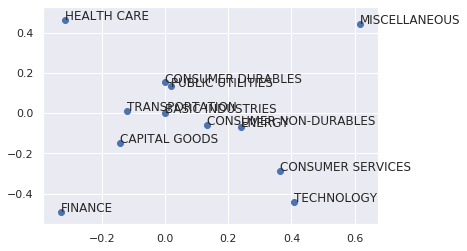

In [214]:
## Sector
emb_id, emb_str = 6, 'sector'
emb_names = train_df[emb_str].cat.categories
emb_weights = to_np(next(learn.layer_groups[0][emb_id].parameters()))
print(len(emb_names), list(emb_names), emb_weights.shape)
# dow_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(dow_weights)
# emb_2d = TSNE(n_components=2, metric='cosine').fit_transform(emb_weights)
emb_2d = PCA(n_components=2).fit(emb_weights.T).components_.T
plt.figure()
# plt.plot(emb2d[:, 0], emb2d[:, 1], 'ro', )
plt.scatter(emb_2d[:-1, 0], emb_2d[:-1, 1] )#, c=range(len(emb_names)) )
for p, s in zip(emb_2d, emb_names):
    plt.annotate(s=s, xy=(p[0], p[1]))

In [213]:
## Industry
emb_id, emb_str = 7, 'industry'
emb_names = train_df[emb_str].cat.categories
print(len(emb_names), list(emb_names))
emb_weights = to_np(next(learn.layer_groups[0][emb_id].parameters()))

print(emb_weights.shape)
# dow_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(dow_weights)
# emb_2d = TSNE(n_components=2, metric='cosine').fit_transform(emb_weights)
emb_2d = PCA(n_components=2).fit(emb_weights.T).components_.T
# plt.figure()
# plt.plot(emb2d[:, 0], emb2d[:, 1], 'ro', )
# plt.scatter(emb_2d[:-1, 0], emb_2d[:-1, 1]  , c=range(len(emb_names)) )
# for p, s in zip(emb_2d, emb_names):
#     plt.annotate(s=s, xy=(p[0], p[1]))

emb_df = info_df.copy()
emb_df['x'] = emb_2d[:-1, 0]
emb_df['y'] = emb_2d[:-1, 1]

# # emb_df
sns.lmplot(x='x', y='y', data=emb_df, fit_reg=False, hue='sector' )#, legend=False)
# plt.legend(loc='best')
plt.show()
emb_2d.shape, emb_df.shape

104 ['ACCIDENT &HEALTH INSURANCE', 'ADVERTISING', 'AEROSPACE', 'AGRICULTURAL CHEMICALS', 'AIR FREIGHT/DELIVERY SERVICES', 'APPAREL', 'AUTO MANUFACTURING', 'AUTO PARTS:O.E.M.', 'AUTOMOTIVE AFTERMARKET', 'BEVERAGES (PRODUCTION/DISTRIBUTION)', 'BIOTECHNOLOGY: BIOLOGICAL PRODUCTS (NO DIAGNOSTIC SUBSTANCES)', 'BIOTECHNOLOGY: COMMERCIAL PHYSICAL & BIOLOGICAL RESARCH', 'BIOTECHNOLOGY: ELECTROMEDICAL & ELECTROTHERAPEUTIC APPARATUS', 'BIOTECHNOLOGY: IN VITRO & IN VIVO DIAGNOSTIC SUBSTANCES', 'BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS', 'BUSINESS SERVICES', 'CATALOG/SPECIALTY DISTRIBUTION', 'CLOTHING/SHOE/ACCESSORY STORES', 'COMPUTER COMMUNICATIONS EQUIPMENT', 'COMPUTER MANUFACTURING', 'COMPUTER PERIPHERAL EQUIPMENT', 'COMPUTER SOFTWARE: PREPACKAGED SOFTWARE', 'COMPUTER SOFTWARE: PROGRAMMING, DATA PROCESSING', 'CONSTRUCTION/AG EQUIPMENT/TRUCKS', 'CONSUMER ELECTRONICS/APPLIANCES', 'CONSUMER ELECTRONICS/VIDEO CHAINS', 'CONSUMER SPECIALTIES', 'CONTAINERS/PACKAGING', 'DEPARTMENT/SPECIALTY RET

ValueError: Length of values does not match length of index

485


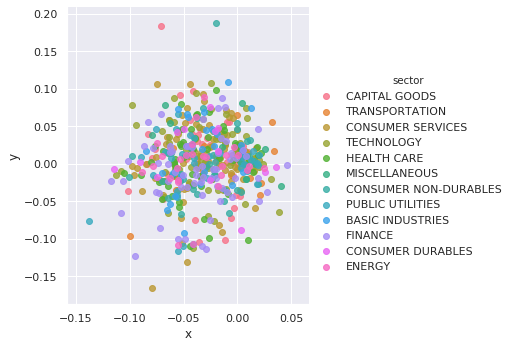

In [244]:
## Ticker
emb_id, emb_str = 4, 'ticker'
emb_names = train_df[emb_str].cat.categories
print(len(emb_names) )#, list(emb_names))
emb_weights = to_np(next(learn.layer_groups[0][emb_id].parameters()))
np.savetxt('tick_emb.tsv', emb_weights, delimiter='\t')

# emb_2d = TSNE(perplexity=60, n_components=2, init='pca', n_iter=int(1e4), random_state=12).fit_transform(emb_weights)
# emb_2d = TSNE(n_components=2, perplexity=50, early_exaggeration=12., learning_rate=200.).fit_transform(emb_weights)
# emb_2d = TSNE(n_components=2, metric='cosine').fit_transform(emb_weights)
emb_2d = PCA(n_components=2).fit(emb_weights.T).components_.T

emb_df = info_df.copy()
emb_df['x'] = emb_2d[:-1, 0]
emb_df['y'] = emb_2d[:-1, 1]

# emb_df
sns.lmplot(x='x', y='y', data=emb_df, fit_reg=False, hue='sector' )#, legend=False)
# plt.legend(loc='best')
plt.show()

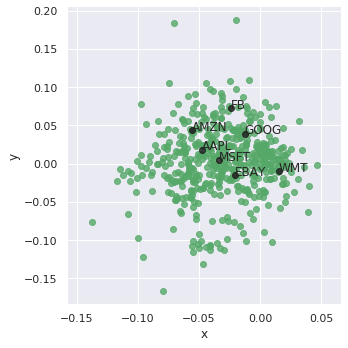

In [267]:
marks = ['AAPL', 'AMZN', 'EBAY', 'FB', 'GOOG', 'MSFT', 'WMT']
emb_df['mark'] = emb_df['ticker'].isin(marks)
sns.lmplot(x='x', y='y', data=emb_df, fit_reg=False, hue='mark', palette=["g", "k"], legend=False)
emb_df = emb_df.drop('mark', axis=1)
for p, s in zip(emb_2d, emb_names):
    if s in marks:
        plt.annotate(s=s, xy=(p[0], p[1]))
plt.show()

In [182]:
tsne_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
emb_3d = tsne_3d.fit_transform(emb_weights)

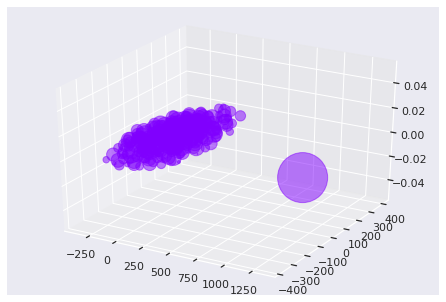

In [217]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

fig = plt.figure()
ax = Axes3D(fig)
colors = cm.rainbow(np.linspace(0, 1, 1))
label = None
plt.scatter(emb_3d[:, 0], emb_3d[:, 1], emb_3d[:, 2], c=colors, alpha=.5, label=label)
# plt.legend(loc=4)
# plt.title('')
plt.show()

In [194]:
info_df = pd.read_csv('./data/historical_stocks.csv')
info_df = info_df.drop(columns=['name'])
tickers = list(df['ticker'].unique())
info_df = info_df[info_df['ticker'].isin(tickers)].sort_values(by='ticker').reset_index(drop=True)
info_df

,ticker,exchange,sector,industry
0,A,NYSE,CAPITAL GOODS,BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS
1,AAL,NASDAQ,TRANSPORTATION,AIR FREIGHT/DELIVERY SERVICES
2,AAP,NYSE,CONSUMER SERVICES,OTHER SPECIALTY STORES
3,AAPL,NASDAQ,TECHNOLOGY,COMPUTER MANUFACTURING
4,ABBV,NYSE,HEALTH CARE,MAJOR PHARMACEUTICALS
5,ABC,NYSE,HEALTH CARE,OTHER PHARMACEUTICALS
6,ABMD,NASDAQ,HEALTH CARE,MEDICAL/DENTAL INSTRUMENTS
7,ABT,NYSE,HEALTH CARE,MAJOR PHARMACEUTICALS
8,ACN,NYSE,MISCELLANEOUS,BUSINESS SERVICES
9,ADBE,NASDAQ,TECHNOLOGY,COMPUTER SOFTWARE: PREPACKAGED SOFTWARE


In [201]:
# plt.scatter(emb_2d[:-1, 0], emb_2d[:-1, 1], c=LabelEncoder().fit_transform(info_df.loc[:, 'sector']) )
emb_df = info_df.copy().set_index('ticker')
wvars = []
for i in range(emb_weights.shape[1]):
    v = 'w%d'%i
    wvars.append(v)
    emb_df[v] = emb_weights[:-1, i]
# emb_df
## One Hot Encoding
for v in ['exchange', 'sector', 'industry']:
    emb_df = pd.concat([emb_df, pd.get_dummies(emb_df[v], prefix=v)], axis=1).drop([v], axis=1)
emb_df
## Normalize
for v in wvars:
    emb_df[v] = (emb_df[v] - emb_df[v].mean()) / emb_df[v].std()
#     emb_df[v] *= 35
# emb_df = (emb_df - emb_df.mean()) / emb_df.std()
emb_df.head()

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16,w17,w18,w19,w20,w21,w22,w23,w24,w25,w26,w27,w28,w29,w30,w31,w32,w33,w34,w35,w36,w37,w38,w39,w40,w41,w42,w43,w44,w45,w46,w47,w48,w49,w50,exchange_NASDAQ,exchange_NYSE,sector_BASIC INDUSTRIES,sector_CAPITAL GOODS,sector_CONSUMER DURABLES,sector_CONSUMER NON-DURABLES,sector_CONSUMER SERVICES,sector_ENERGY,sector_FINANCE,sector_HEALTH CARE,sector_MISCELLANEOUS,sector_PUBLIC UTILITIES,sector_TECHNOLOGY,sector_TRANSPORTATION,industry_ACCIDENT &HEALTH INSURANCE,industry_ADVERTISING,industry_AEROSPACE,industry_AGRICULTURAL CHEMICALS,industry_AIR FREIGHT/DELIVERY SERVICES,industry_APPAREL,industry_AUTO MANUFACTURING,industry_AUTO PARTS:O.E.M.,industry_AUTOMOTIVE AFTERMARKET,industry_BEVERAGES (PRODUCTION/DISTRIBUTION),industry_BIOTECHNOLOGY: BIOLOGICAL PRODUCTS (NO DIAGNOSTIC SUBSTANCES),industry_BIOTECHNOLOGY: COMMERCIAL PHYSICAL & BIOLOGICAL RESARCH,industry_BIOTECHNOLOGY: ELECTROMEDICAL & ELECTROTHERAPEUTIC APPARATUS,industry_BIOTECHNOLOGY: IN VITRO & IN VIVO DIAGNOSTIC SUBSTANCES,industry_BIOTECHNOLOGY: LABORATORY ANALYTICAL INSTRUMENTS,industry_BUSINESS SERVICES,industry_CATALOG/SPECIALTY DISTRIBUTION,industry_CLOTHING/SHOE/ACCESSORY STORES,industry_COMPUTER COMMUNICATIONS EQUIPMENT,industry_COMPUTER MANUFACTURING,industry_COMPUTER PERIPHERAL EQUIPMENT,industry_COMPUTER SOFTWARE: PREPACKAGED SOFTWARE,"industry_COMPUTER SOFTWARE: PROGRAMMING, DATA PROCESSING",industry_CONSTRUCTION/AG EQUIPMENT/TRUCKS,industry_CONSUMER ELECTRONICS/APPLIANCES,industry_CONSUMER ELECTRONICS/VIDEO CHAINS,industry_CONSUMER SPECIALTIES,industry_CONTAINERS/PACKAGING,industry_DEPARTMENT/SPECIALTY RETAIL STORES,industry_DIVERSIFIED COMMERCIAL SERVICES,industry_EDP SERVICES,industry_ELECTRIC UTILITIES: CENTRAL,industry_ELECTRICAL PRODUCTS,industry_ELECTRONIC COMPONENTS,industry_ENGINEERING & CONSTRUCTION,industry_ENVIRONMENTAL SERVICES,industry_FARMING/SEEDS/MILLING,industry_FINANCE: CONSUMER SERVICES,industry_FLUID CONTROLS,industry_FOOD CHAINS,industry_FOOD DISTRIBUTORS,industry_FOREST PRODUCTS,industry_HOME FURNISHINGS,industry_HOMEBUILDING,industry_HOSPITAL/NURSING MANAGEMENT,industry_HOTELS/RESORTS,industry_INDUSTRIAL MACHINERY/COMPONENTS,industry_INDUSTRIAL SPECIALTIES,industry_INTEGRATED OIL COMPANIES,industry_INVESTMENT BANKERS/BROKERS/SERVICE,industry_INVESTMENT MANAGERS,industry_LIFE INSURANCE,industry_MAJOR BANKS,industry_MAJOR CHEMICALS,industry_MAJOR PHARMACEUTICALS,industry_MARINE TRANSPORTATION,industry_MEAT/POULTRY/FISH,industry_MEDICAL ELECTRONICS,industry_MEDICAL SPECIALITIES,industry_MEDICAL/DENTAL INSTRUMENTS,industry_MEDICAL/NURSING SERVICES,industry_METAL FABRICATIONS,industry_MILITARY/GOVERNMENT/TECHNICAL,industry_MINING & QUARRYING OF NONMETALLIC MINERALS (NO FUELS),industry_MOTOR VEHICLES,industry_NATURAL GAS DISTRIBUTION,industry_NEWSPAPERS/MAGAZINES,industry_OFFICE EQUIPMENT/SUPPLIES/SERVICES,industry_OIL & GAS PRODUCTION,industry_OIL REFINING/MARKETING,industry_OIL/GAS TRANSMISSION,industry_OILFIELD SERVICES/EQUIPMENT,industry_OPHTHALMIC GOODS,industry_OTHER CONSUMER SERVICES,industry_OTHER PHARMACEUTICALS,industry_OTHER SPECIALTY STORES,industry_PACKAGE GOODS/COSMETICS,industry_PACKAGED FOODS,industry_PAINTS/COATINGS,industry_PAPER,industry_PLASTIC PRODUCTS,industry_POWER GENERATION,industry_PRECIOUS METALS,industry_PROFESSIONAL SERVICES,industry_PROPERTY-CASUALTY INSURERS,industry_RADIO AND TELEVISION BROADCASTING AND COMMUNICATIONS EQUIPMENT,industry_RAILROADS,industry_REAL ESTATE,industry_REAL ESTATE INVESTMENT TRUSTS,industry_RECREATIONAL PRODUCTS/TOYS,industry_RESTAURANTS,industry_RETAIL: BUILDING MATERIALS,industry_SAVINGS INSTITUTIONS,industry_SEMICONDUCTORS,industry_SHOE MANUFACTURING,industry_SPECIALTY CHEMICALS,industry_SPECIALTY FOODS,industry_SPECIALTY INSURERS,industry_STEEL/IRON ORE,industry_TELECOMMUNICATIONS EQUIPMENT,industry_TELEVISION SERVICES,industry_TRANSPORTATION SERVICES,industry_TRUCKING FREIGHT/COURIER SERVICES,industry_WATER SUPPLY
ticker,,,,,,,,

IndexError: invalid index to scalar variable.

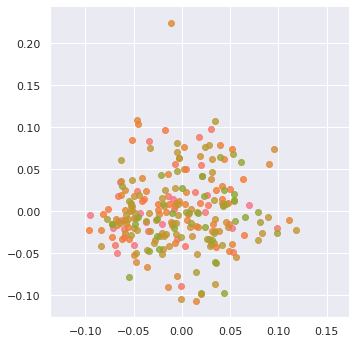

In [202]:
# emb_2d = TSNE(n_components=2, metric='cosine').fit_transform(df.values)
emb_2d = PCA(n_components=2).fit(emb_df.values.T).components_.T
emb_2d.shape

df_ = info_df.copy()
df_['x'] = emb_2d[:, 0]
df_['y'] = emb_2d[:, 1]

# # # emb_df
sns.lmplot(x='x', y='y', data=df_, fit_reg=False, hue='industry', legend=False)
# plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans().fit(emb_weights)